In [1]:
import numpy as np
from ESN import Esn
from ESN_SCALING import Esn as Esn_new
from lorenz import lorenz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mse(outputs, targets):
    if outputs.size != targets.size:
        raise ValueError(u"Ouputs and targets ndarray don have the same number of elements")
    return np.mean(np.linalg.norm(outputs - targets, ord=2, axis=0))

def loss_func(x, y):
    loss = np.linalg.norm(x - y, ord=2, axis=0)
    return loss

In [3]:
def random_grid_search(train_data, test_data, hidden_range, radius_range, leaky_range, num_samples):
    # transient washout=100
    train_inputs = train_data
    test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
    test_length = 1000
    assert test_targets.shape[1]>test_length
    test_targets = test_targets[:, :test_length]

    hidden = np.random.randint(hidden_range[0], hidden_range[1], size=num_samples, dtype=np.int32)
    radius = np.random.rand(num_samples) * (radius_range[1] - radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples) * (leaky_range[1] - leaky_range[0]) + leaky_range[0]

    min_error = None
    min_hidden, min_radius, min_leaky = None, None, None
    mses = []

    for hid, rad, leak in zip(hidden, radius, leaky):
        esn = Esn(n_inputs=3,
                  n_outputs=3,
                  n_reservoir=int(hid),
                  leaky_rate=leak,
                  spectral_radius=rad,
                  random_state=None,
                  sparsity=0.4,
                  silent=True,
                  ridge_param=1e-7)
        esn.fit(train_inputs)

        prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
        error = mse(test_targets, prediction)
        if not min_error or error < min_error:
            min_error, min_hidden, min_radius, min_leaky = error, hid, rad, leak
        mses.append(error)

    return min_error, min_hidden, min_radius, min_leaky, mses

# No scaling ESN with Linear Regression

harvesting states...
train length 3999
mse: 0.003858201545580827


Text(0.5, 1.0, 'LRESN_without noise')

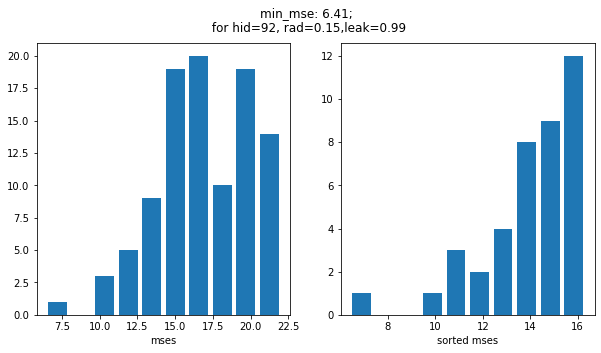

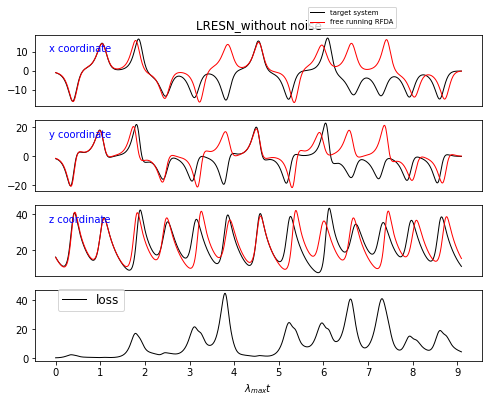

In [4]:
dt = 0.01
model = lorenz(10., 28., 8 / 3, dt)
states = model.propagate(80, 10)
train_data = states[:, :4000]
model = lorenz(10., 28., 8 / 3, dt, 4)
states = model.propagate(40, 10)
test_data = states[:, -2000:]
del states


# min_mse, min_hidden, min_radius, min_leaky, mses = random_grid_search(
#     train_data,
#     test_data,
#     hidden_range=[80, 200],
#     radius_range=[0.1, 1.3],
#     leaky_range=[0.5, 0.99],
#     num_samples=100,
# )
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs = axs.flatten()
# axs[0].hist(mses, rwidth=0.8)
# axs[0].set_xlabel("mses")
# axs[1].hist(sorted(mses)[:40], rwidth=0.8)
# axs[1].set_xlabel("sorted mses")
# fig.suptitle(f'min_mse: {min_mse:.2f};\n for hid={min_hidden}, rad={min_radius:.2f},leak={min_leaky:.2f}')

esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=int(92),
          leaky_rate=0.99,
          spectral_radius=0.15,
          random_state=None,
          sparsity=0.4,
          silent=False)

test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
test_length = 1000
assert test_targets.shape[1]>test_length
test_targets = test_targets[:, :test_length]
esn.fit(train_data)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
error = mse(test_targets, prediction)

lyapunov_exp = 0.91
max_time_unit = int(test_length * dt / lyapunov_exp)
time_ticks = [l / lyapunov_exp / dt for l in range(max_time_unit)]
fig, ax = plt.subplots(4, 1, figsize=(8, 6))
ax = ax.flatten()
coords = ["x coordinate", "y coordinate", "z coordinate"]
loss = loss_func(test_targets, prediction)
for i in range(3):
    ax[i].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i].set_xticks([])
    ax[i].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i].transAxes)
ax[3].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3].legend(loc=(0.05, 0.7), fontsize=12)
ax[0].legend(loc=(0.61, 1.1), fontsize='x-small')
ax[3].set_xticks(time_ticks)
ax[3].set_xticklabels(np.arange(max_time_unit))
ax[3].set_xlabel('$ \lambda_{max}t $')
ax[0].set_title("LRESN_without noise")

# Data assimilation for ESN


harvesting states...
train length 3999
mse: 0.0036089659306988093
 da idx 97

E:\PycarmProjects2\reservoir_computing\Learn_functions\ESN.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  R, _, _, _ = np.linalg.lstsq(P_uu + u_cov, u_forecast - u_ob_noise)


Text(0.5, 1.0, 'LRESN_without noise')

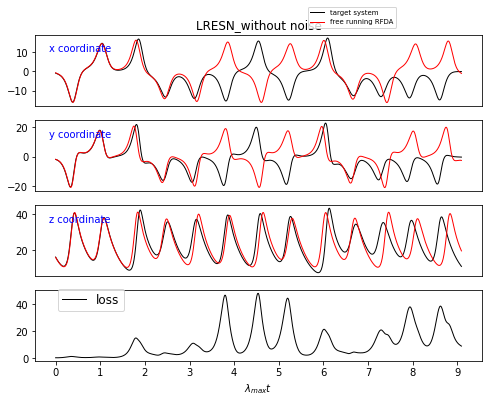

In [5]:
dt = 0.01
model = lorenz(10., 28., 8 / 3, dt)
states = model.propagate(80, 10)
train_data = states[:, :4000]
model = lorenz(10., 28., 8 / 3, dt, 4)
states = model.propagate(40, 10)
test_data = states[:, -2000:]
del states

esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=92,
          leaky_rate=0.987,
          spectral_radius=0.148,
          random_state=None,
          sparsity=0.4,
          silent=False)

test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
test_length = 1000
assert test_targets.shape[1]>test_length
test_targets = test_targets[:, :test_length]
esn.fit_da(train_data, None, ensembles=100, eta=1e-4, gamma=1000.)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
error = mse(test_targets, prediction)

lyapunov_exp = 0.91
max_time_unit = int(test_length * dt / lyapunov_exp)
time_ticks = [l / lyapunov_exp / dt for l in range(max_time_unit)]
fig, ax = plt.subplots(4, 1, figsize=(8, 6))
ax = ax.flatten()
coords = ["x coordinate", "y coordinate", "z coordinate"]
loss = loss_func(test_targets, prediction)
for i in range(3):
    ax[i].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i].set_xticks([])
    ax[i].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i].transAxes)
ax[3].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3].legend(loc=(0.05, 0.7), fontsize=12)
ax[0].legend(loc=(0.61, 1.1), fontsize='x-small')
ax[3].set_xticks(time_ticks)
ax[3].set_xticklabels(np.arange(max_time_unit))
ax[3].set_xlabel('$ \lambda_{max}t $')
ax[0].set_title("LRESN_without noise")


# Noise data, ESN with Linear Regression

harvesting states...
train length 3999
mse: 0.8441752502538181


Text(0.5, 1.0, 'LRESN_with noise')

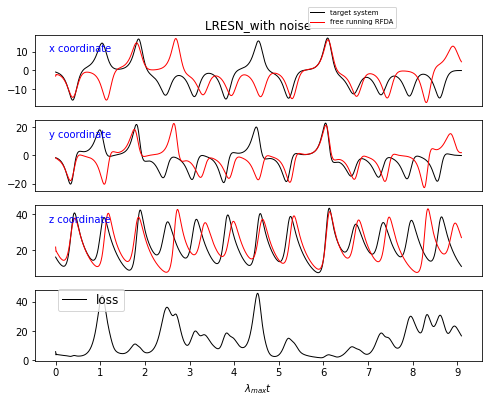

In [4]:
dt = 0.01
model = lorenz(10., 28., 8 / 3, dt)
states = model.propagate(80, 10)
train_data = states[:, :4000]
model = lorenz(10., 28., 8 / 3, dt, 4)
states = model.propagate(40, 10)
test_data = states[:, -2000:]
del states

esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=int(92),
          leaky_rate=0.99,
          spectral_radius=0.15,
          random_state=None,
          sparsity=0.4,
          silent=False)

eta = 0.2
train_data = train_data + np.random.multivariate_normal(np.zeros(3), np.eye(3) * eta, size=4000).T
test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
test_length = 1000
assert test_targets.shape[1]>test_length
test_targets = test_targets[:, :test_length]
esn.fit(train_data)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
error = mse(test_targets, prediction)

lyapunov_exp = 0.91
max_time_unit = int(test_length * dt / lyapunov_exp)
time_ticks = [l / lyapunov_exp / dt for l in range(max_time_unit)]
fig, ax = plt.subplots(4, 1, figsize=(8, 6))
ax = ax.flatten()
coords = ["x coordinate", "y coordinate", "z coordinate"]
loss = loss_func(test_targets, prediction)
for i in range(3):
    ax[i].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i].set_xticks([])
    ax[i].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i].transAxes)
ax[3].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3].legend(loc=(0.05, 0.7), fontsize=12)
ax[0].legend(loc=(0.61, 1.1), fontsize='x-small')
ax[3].set_xticks(time_ticks)
ax[3].set_xticklabels(np.arange(max_time_unit))
ax[3].set_xlabel('$ \lambda_{max}t $')
ax[0].set_title("LRESN_with noise")

# Noise data, ESN with DA

harvesting states...
train length 3999
mse: 0.840944549464929


Text(0.5, 1.0, 'LRESN_without noise')

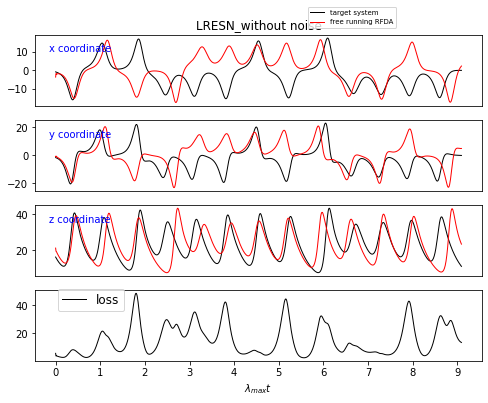

In [8]:
dt = 0.01
model = lorenz(10., 28., 8 / 3, dt)
states = model.propagate(80, 10)
train_data = states[:, :4000]
model = lorenz(10., 28., 8 / 3, dt, 4)
states = model.propagate(40, 10)
test_data = states[:, -2000:]
del states

esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=92,
          leaky_rate=0.987,
          spectral_radius=0.148,
          random_state=None,
          sparsity=0.4,
          silent=False)
eta = 0.2
train_data = train_data + np.random.multivariate_normal(np.zeros(3), np.eye(3) * eta, size=4000).T
test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
test_length = 1000
assert test_targets.shape[1]>test_length
test_targets = test_targets[:, :test_length]
esn.fit_da(train_data, None, ensembles=100, eta=0.2, gamma=1000.)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
error = mse(test_targets, prediction)

lyapunov_exp = 0.91
max_time_unit = int(test_length * dt / lyapunov_exp)
time_ticks = [l / lyapunov_exp / dt for l in range(max_time_unit)]
fig, ax = plt.subplots(4, 1, figsize=(8, 6))
ax = ax.flatten()
coords = ["x coordinate", "y coordinate", "z coordinate"]
loss = loss_func(test_targets, prediction)
for i in range(3):
    ax[i].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i].set_xticks([])
    ax[i].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i].transAxes)
ax[3].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3].legend(loc=(0.05, 0.7), fontsize=12)
ax[0].legend(loc=(0.61, 1.1), fontsize='x-small')
ax[3].set_xticks(time_ticks)
ax[3].set_xticklabels(np.arange(max_time_unit))
ax[3].set_xlabel('$ \lambda_{max}t $')
ax[0].set_title("LRESN_without noise")

